# Decision Tree Learning: College Admission

A decision tree a learned set of rules that allows us to make decisions on data.

We are going to look at the prosper loan dataset.  This dataset shows a history of loans made by Prosper.

In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /Users/sujee/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/var/folders/lp/qm_skljd2hl4xtps5vw0tdgm0000gn/T/tmpxh4161ot
	some_property=some_value
Spark UI running on port 4040


## Step 1: Load the Data

In [2]:
dataset = spark.read.csv("/data/college-admissions/admission-data.csv", 
                         header=True, inferSchema=True)
## clean 
dataset = dataset.na.drop()

dataset.printSchema()
dataset.show(20)

root
 |-- admit: integer (nullable = true)
 |-- gre: integer (nullable = true)
 |-- gpa: double (nullable = true)
 |-- rank: integer (nullable = true)

+-----+---+----+----+
|admit|gre| gpa|rank|
+-----+---+----+----+
|    0|380|3.61|   3|
|    1|660|3.67|   3|
|    1|800| 4.0|   1|
|    0|640|3.19|   4|
|    0|520|2.93|   4|
|    1|760| 3.0|   2|
|    0|560|2.98|   1|
|    0|400|3.08|   2|
|    0|540|3.39|   3|
|    1|700|3.92|   2|
|    1|800| 4.0|   4|
|    0|440|3.22|   1|
|    1|760| 4.0|   1|
|    1|700|3.08|   2|
|    1|700| 4.0|   1|
|    0|480|3.44|   3|
|    1|780|3.87|   4|
|    0|360|2.56|   3|
|    1|800|3.75|   2|
|    0|540|3.81|   1|
+-----+---+----+----+
only showing top 20 rows



## Step 2 : Basic Analysis

### 2.1 Look at data split by 'admit' colunm
Looks like a resaonble distribution

In [3]:
## TODO : group by 'admit' column
dataset.groupBy('admit').count().show()

+-----+-----+
|admit|count|
+-----+-----+
|    1|   43|
|    0|   57|
+-----+-----+



### 2.2 Summary of data
use 'describe' function

In [4]:
dataset.describe().show()

+-------+-------------------+------------------+------------------+-----------------+
|summary|              admit|               gre|               gpa|             rank|
+-------+-------------------+------------------+------------------+-----------------+
|  count|                100|               100|               100|              100|
|   mean|               0.43|             600.0| 3.390699999999998|             2.52|
| stddev|0.49756985195624304|124.46248065545332|0.3971877275408833|1.019803902718557|
|    min|                  0|               300|              2.42|                1|
|    max|                  1|               800|               4.0|                4|
+-------+-------------------+------------------+------------------+-----------------+



## Step 3: Build feature vectors using VectorAssembler.

In [5]:
from pyspark.ml.feature import VectorAssembler

## TODO : create a feature vector using the following attributes
## Hint :   'gpa' ,   'gre',   'rank'
assembler = VectorAssembler(inputCols=['gpa', 'gre', 'rank'], outputCol="features")
feature_vector = assembler.transform(dataset)

## TODO : set 'admit' as 'label' column
feature_vector = feature_vector.withColumn("label", feature_vector["admit"])
feature_vector.show()

+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|380|3.61|   3|[3.61,380.0,3.0]|    0|
|    1|660|3.67|   3|[3.67,660.0,3.0]|    1|
|    1|800| 4.0|   1| [4.0,800.0,1.0]|    1|
|    0|640|3.19|   4|[3.19,640.0,4.0]|    0|
|    0|520|2.93|   4|[2.93,520.0,4.0]|    0|
|    1|760| 3.0|   2| [3.0,760.0,2.0]|    1|
|    0|560|2.98|   1|[2.98,560.0,1.0]|    0|
|    0|400|3.08|   2|[3.08,400.0,2.0]|    0|
|    0|540|3.39|   3|[3.39,540.0,3.0]|    0|
|    1|700|3.92|   2|[3.92,700.0,2.0]|    1|
|    1|800| 4.0|   4| [4.0,800.0,4.0]|    1|
|    0|440|3.22|   1|[3.22,440.0,1.0]|    0|
|    1|760| 4.0|   1| [4.0,760.0,1.0]|    1|
|    1|700|3.08|   2|[3.08,700.0,2.0]|    1|
|    1|700| 4.0|   1| [4.0,700.0,1.0]|    1|
|    0|480|3.44|   3|[3.44,480.0,3.0]|    0|
|    1|780|3.87|   4|[3.87,780.0,4.0]|    1|
|    0|360|2.56|   3|[2.56,360.0,3.0]|    0|
|    1|800|3.75|   2|[3.75,800.0,2.0]|    1|
|    0|540

## Step 4: Split Data into training and test.

We will split our the data up into training and test.  (You know the drill by now).

**=> TODO: Split dataset into 80% training, 20% validation**


In [6]:
## TODO :  Split the data into 80% training and 20% test sets 
## Hint :  0.8,   0.2
(training, test) =  feature_vector.randomSplit([.8,   .2])
#(training, test) =  feature_vector.randomSplit([???,   ???], seed=123)  # seed can be any number
print("training set = " , training.count())
print("testing set = " , test.count())

training set =  82
testing set =  18


## Step 5: Decision Tree

### 5.1 Create tree

In [7]:
from pyspark.ml.classification import DecisionTreeClassifier

## TODO : Create a DecisionTree model with maximum bins = 500
## 
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=500)


dt

DecisionTreeClassifier_45d5b6f91b025b6791ae

### 5.2 Train Tree

In [8]:
%%time

## TODO : train model on training dataset
## Hint : pass 'training' dataset name

print("training starting...")
model = dt.fit(training)
print("training done.")



training starting...
training done.
CPU times: user 15.6 ms, sys: 4.57 ms, total: 20.2 ms
Wall time: 863 ms


### 5.3 Print Tree

In [9]:

## print the model
print(model)
print()
print(model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_45d5b6f91b025b6791ae) of depth 5 with 23 nodes

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_45d5b6f91b025b6791ae) of depth 5 with 23 nodes
  If (feature 1 <= 610.0)
   If (feature 1 <= 490.0)
    Predict: 0.0
   Else (feature 1 > 490.0)
    If (feature 0 <= 3.125)
     If (feature 0 <= 2.6950000000000003)
      If (feature 0 <= 2.45)
       Predict: 0.0
      Else (feature 0 > 2.45)
       Predict: 1.0
     Else (feature 0 > 2.6950000000000003)
      Predict: 0.0
    Else (feature 0 > 3.125)
     If (feature 0 <= 3.165)
      Predict: 1.0
     Else (feature 0 > 3.165)
      If (feature 0 <= 3.395)
       Predict: 0.0
      Else (feature 0 > 3.395)
       Predict: 0.0
  Else (feature 1 > 610.0)
   If (feature 0 <= 3.38)
    If (feature 1 <= 750.0)
     If (feature 2 <= 2.5)
      If (feature 0 <= 3.075)
       Predict: 0.0
      Else (feature 0 > 3.075)
       Predict: 1.0
     Else (feature 2 > 2.5)
      Predi

## Step 6 : Get Predictions on Test

In [10]:
## TODO : Get predictions on test data
## Hint : 'test' set name
predictions_test = model.transform(test)
predictions_test.show()

## do a sample label
predictions_test.sampleBy(col="label", fractions={0: 0.5, 1: 0.5}, seed=123).show()

+-----+---+----+----+----------------+-----+-------------+--------------------+----------+
|admit|gre| gpa|rank|        features|label|rawPrediction|         probability|prediction|
+-----+---+----+----+----------------+-----+-------------+--------------------+----------+
|    0|400|3.08|   2|[3.08,400.0,2.0]|    0|   [13.0,0.0]|           [1.0,0.0]|       0.0|
|    0|400|3.65|   2|[3.65,400.0,2.0]|    0|   [13.0,0.0]|           [1.0,0.0]|       0.0|
|    0|480|3.39|   4|[3.39,480.0,4.0]|    0|   [13.0,0.0]|           [1.0,0.0]|       0.0|
|    0|480|3.44|   3|[3.44,480.0,3.0]|    0|   [13.0,0.0]|           [1.0,0.0]|       0.0|
|    0|500|3.17|   3|[3.17,500.0,3.0]|    0|    [8.0,1.0]|[0.88888888888888...|       0.0|
|    0|580| 4.0|   2| [4.0,580.0,2.0]|    0|    [6.0,4.0]|           [0.6,0.4]|       0.0|
|    0|620| 3.3|   1| [3.3,620.0,1.0]|    0|    [1.0,3.0]|         [0.25,0.75]|       1.0|
|    0|640|3.52|   4|[3.52,640.0,4.0]|    0|   [0.0,21.0]|           [0.0,1.0]|       1.0|

## Step 7: Evaluate the model.

Let us check to see how the model did, using accuracy as a measure.

In [11]:
predictions_test = model.transform(test)
predictions_train = model.transform(training)

### 7.1 Model Accuracy

In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.926829268292683
Test set accuracy =  0.7222222222222222


### 7.2 Confusion Matrix

In [13]:
## Group by 'admit' 
cm = predictions_test.groupBy('admit').pivot('prediction', [0,1]).count().na.fill(0).orderBy('admit')
cm.show()

+-----+---+---+
|admit|  0|  1|
+-----+---+---+
|    0|  6|  4|
|    1|  1|  7|
+-----+---+---+



[]

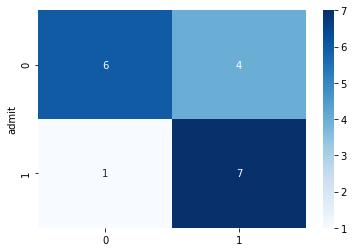

In [15]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("admit", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True, fmt=',', cmap="Blues").plot()

## Step 8: Do a Few Runs
- Click 'Cell --> Run All'
- Observe how the 'accuracy' output changes above
- Why?  Can we get the same accuracy all the times?

To get 'consistant' split for testing and random data you can set the seed variable

```python
(training, test) =  feature_vector.randomSplit([0.7,   0.3], seed=123)
```